In [4]:
%matplotlib inline
import numpy as np
from PIL import Image
from keras.models import model_from_json
from keras.optimizers import RMSprop
from mask_utils import get_images, get_input_prediction_tiles, image_from_tiles, \
                       image_generator, get_score_mask_images
from glob import glob

Load the model & weights that were most-recently created by train_mask_model.py.

In [2]:
model_file   = 'data/results/model_180106.json'
weights_file = 'data/results/mask_weights_180106_143329.h5'

with open(model_file,"r") as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(weights_file)
# compile the model for evaluate()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=["accuracy"])

Create a set of images to check vs. the model.

In [3]:
#train_score_images, train_mask_images = get_score_mask_images('data/train')
valid_score_images, valid_mask_images = get_score_mask_images('data/valid')
test_score_images, test_mask_images = get_score_mask_images('data/valid')
#num_train_images,rows,cols,channels = train_score_images.shape
num_valid_images,rows,cols,channels  = valid_score_images.shape
num_test_images,_,_,_ = test_score_images.shape
batch_size = 32
#train_generator = image_generator(train_score_images, train_mask_images,
#                                  batch_size, channels)
valid_generator = image_generator(valid_score_images, valid_mask_images,
                                  batch_size, channels)
test_generator = image_generator(test_score_images, test_mask_images,
                                  batch_size, channels)

Evaluate the compiled model vs the validation & test sets. 
The validation score should match what you saw in the output of your training log.

In [4]:
# does this match your expectation?
model.evaluate_generator(valid_generator,steps=num_valid_images//batch_size)

[0.005416103920358564, 0.9993873103972404]

In [5]:
# here are some images that were never seen by the model before.
# we hope they get a score similar to the validation set.
model.evaluate_generator(test_generator,steps=num_test_images//batch_size)

[0.005416103901581899, 0.9993873103972404]

Now loop through the test cases, predicting the images and storing them as mask png files.

In [5]:
base_list = [x.replace('.png','').replace('../setup/','').replace('_mask','') for x in sorted(glob("../setup/*_mask.png"))]
base_list.remove('chromatic_piano') # FIXME dropping chromatic_piano temporarily
base_list

['chromatic',
 'frere',
 'gen_key_a',
 'gen_key_aes',
 'gen_key_b',
 'gen_key_bes',
 'gen_key_ces',
 'gen_key_cis',
 'gen_key_d',
 'gen_key_des',
 'gen_key_e',
 'gen_key_ees',
 'gen_key_f',
 'gen_key_fis',
 'gen_key_g',
 'gen_key_ges',
 'gen_one',
 'gen_three_1',
 'gen_three_2',
 'gen_three_3',
 'gen_two',
 'twinkle']

In [6]:
#for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
mask_images = {}
pred_images = {}
for base_name in base_list:
    print(f"predicting {base_name}")
    score_image, mask_images[base_name] = get_images(base_name)
    input_tiles = get_input_prediction_tiles(score_image)
    pred_tiles = model.predict(input_tiles)
    pred_images[base_name] = image_from_tiles(score_image.width, score_image.height, 
                                             input_tiles.shape[0], pred_tiles, 1)
    with open(f"data/results/pred_mask_{base_name}.png",'wb') as f:
        pred_images[base_name].save(f)

predicting chromatic
predicting frere
predicting gen_key_a
predicting gen_key_aes
predicting gen_key_b
predicting gen_key_bes
predicting gen_key_ces
predicting gen_key_cis
predicting gen_key_d
predicting gen_key_des
predicting gen_key_e
predicting gen_key_ees
predicting gen_key_f
predicting gen_key_fis
predicting gen_key_g
predicting gen_key_ges
predicting gen_one
predicting gen_three_1
predicting gen_three_2
predicting gen_three_3
predicting gen_two
predicting twinkle


Compare the predicted vs. expected images... You'll probably want to do this outside of Jupyter notebook...

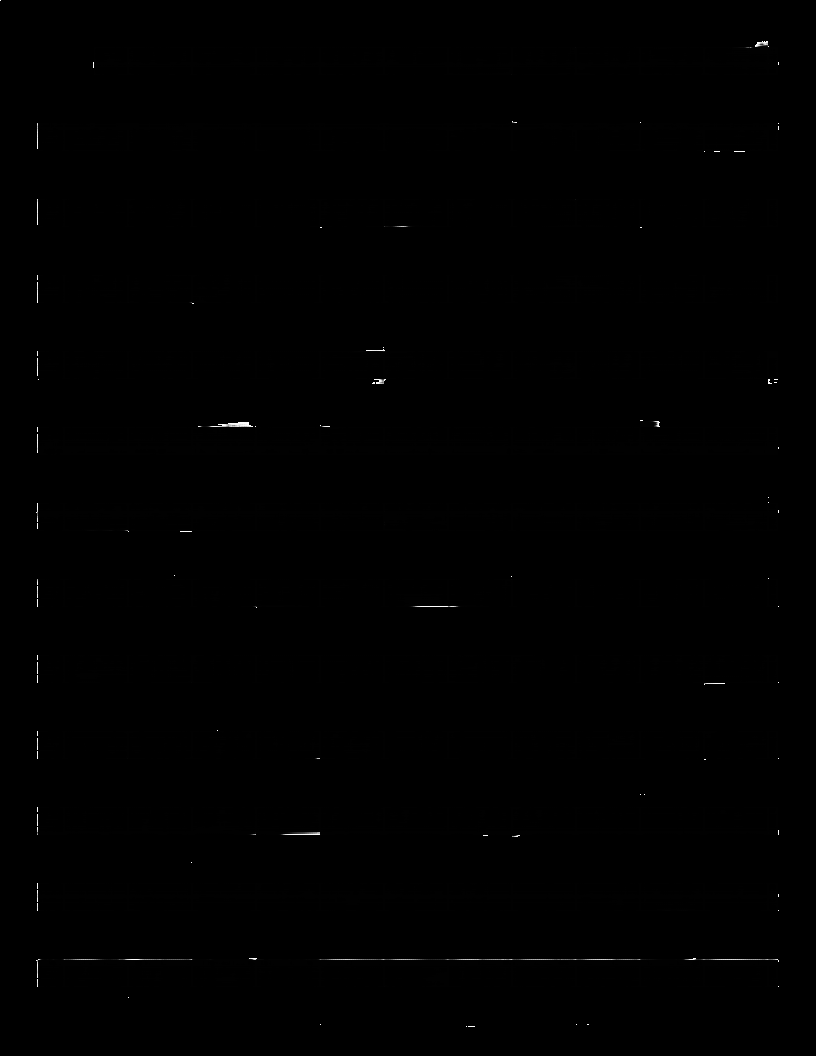

In [10]:
# pred_images size is "rounded up" by grid size
base = 'gen_three_2'
w, h = mask_images[base].width, mask_images[base].height
diff_ary = np.abs(np.asarray(mask_images[base]) - np.asarray(pred_images[base].crop((0,0,w,h))))
diff_ary[0][0] = 255 # to make sure display scale is right, put 255 in (0,0)
Image.fromarray(diff_ary,'L')
#pred_images[base]
#mask_images[base]